<a href="https://colab.research.google.com/github/JaiBhagat/Data-Science-Projects/blob/master/S9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [ ]:
#@title
'''Some helper functions for PyTorch, including:
    - get_mean_and_std: calculate the mean and std value of dataset.
    - msr_init: net parameter initialization.
    - progress_bar: progress bar mimic xlua.progress.
'''
import os
import sys
import time
import math
import shutil

import torch
import torch.nn as nn
import torch.nn.init as init


def get_mean_and_std(dataset):
    '''Compute the mean and std value of dataset.'''
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    print('==> Computing mean and std..')
    for inputs, targets in dataloader:
        for i in range(3):
            mean[i] += inputs[:,i,:,:].mean()
            std[i] += inputs[:,i,:,:].std()
    mean.div_(len(dataset))
    std.div_(len(dataset))
    return mean, std

def init_params(net):
    '''Init layer parameters.'''
    for m in net.modules():
        if isinstance(m, nn.Conv2d):
            init.kaiming_normal(m.weight, mode='fan_out')
            if m.bias:
                init.constant(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant(m.weight, 1)
            init.constant(m.bias, 0)
        elif isinstance(m, nn.Linear):
            init.normal(m.weight, std=1e-3)
            if m.bias:
                init.constant(m.bias, 0)


_, term_width = shutil.get_terminal_size()
term_width = int(term_width)

TOTAL_BAR_LENGTH = 65.
last_time = time.time()
begin_time = last_time
def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time = time.time()
    step_time = cur_time - last_time
    last_time = cur_time
    tot_time = cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(term_width-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(term_width-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current < total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

In [ ]:
!pip install -U albumentations

In [5]:
#@title
import albumentations as A
import cv2

# # Declare an augmentation pipeline
# transform = A.Compose([
#     A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])

# # Read an image with OpenCV and convert it to the RGB colorspace
# image = cv2.imread("image.jpg")
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# # Augment an image
# transformed = transform(image=image)
# transformed_image = transformed["image"]

In [37]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms

# PyTorch Train Phase transformations
train_transforms_torch = transforms.Compose([
                                       transforms.RandomCrop(32, padding=4, padding_mode='reflect'),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.RandomRotation(15),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       ])

# Albumentations Train Phase transformations
train_transforms_albu = A.Compose([
                                       A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                                       A.HorizontalFlip(p=0.5),
                                       A.RandomBrightnessContrast(p=0.2),
                                       A.RandomContrast(limit=0.2),
                                       A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, p=0.2,border_mode=cv2.BORDER_REFLECT_101),
                                       A.CoarseDropout(max_holes=1, max_height=16,fill_value=(0.4914, 0.4822, 0.4465),mask_fill_value = None),
                                       ToTensorV2(),

                                       ])

# PyTorch Test Phase transformations
test_transforms_torch = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                                       ])


In [38]:
train = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms_albu)
test = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms_torch)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# SEED = 1

# # CUDA?
# cuda = torch.cuda.is_available()
# print("CUDA Available?", cuda)

# # For reproducibility
# torch.manual_seed(SEED)

# if cuda:
#     torch.cuda.manual_seed(SEED)

# # dataloader arguments - something you'll fetch these from cmdprmt
# dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# # train dataloader
# train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# # test dataloader
# test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

In [39]:
from torch.utils.data import Dataset
import cv2

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=512, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

class CustomDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.LongTensor(targets)
        self.transform = transform

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]

        # Convert the image from PIL format to numpy (required for Albumentations)
        img = np.array(img)

        if self.transform is not None:
            # Apply transformations. Albumentations requires input as a dictionary for image data
            augmented = self.transform(image=img)
            img = augmented['image']  # retrieve image from dictionary

        return img, target

    def __len__(self):
        return len(self.data)

#instead of using torchvision's CIFAR10 directly, using this CustomDataset class and pass the CIFAR10 dataset's data and targets to it:
from torchvision.datasets import CIFAR10

# Load CIFAR10 dataset
dataset = CIFAR10(root='./data', train=True, download=True)

# Create the custom dataset
custom_dataset = CustomDataset(dataset.data, dataset.targets, transform=train_transforms_albu)

# Now, create your data loader with this custom dataset
train_loader = torch.utils.data.DataLoader(custom_dataset, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True
Files already downloaded and verified


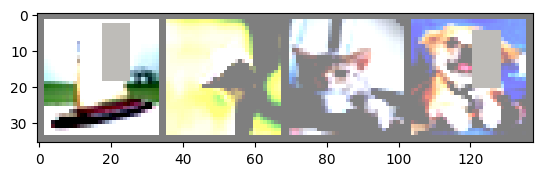

ship  bird  cat   dog  


In [40]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

import torchvision
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
#@title
import os
import PIL
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torchvision.utils import make_grid, save_image

def myfunc():
    abc = 10
    print(abc)

def transformations():

    transform_train = AlbumentationTransformTrain()
    transform_test = AlbumentationTransformTest()

    return (transform_train, transform_test)


def loadcifar10dataset(transform_train, transform_test):
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

    testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=True, num_workers=2)

    return (trainset, trainloader, testset, testloader)

def getclasses():
    return ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def getoptimizer(network):
    return optim.Adam(network.parameters(), lr=0.001)
    # return optim.SGD(network.parameters(), lr=0.001, momentum=0.9)

def train(network, trainloader, device, optimizer, criterion, epoch):
    print('\nEpoch: %d' % epoch)
    network.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = network(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        progress_bar(batch_idx, len(trainloader), 'Train >> Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))

        '''print('Train:: Loss: %.3f | Acc: %.3f%% (%d/%d)'
            % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))'''

def test(network, testloader, device, criterion, epoch):
    network.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = network(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            progress_bar(batch_idx, len(testloader), 'Test >> Loss: %.3f | Acc: %.3f%% (%d/%d)'
                % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def loadimage(imagedirectory, imagename):
    # Load Image
    imgpath = os.path.join(imagedirectory, imagename)
    pilimg = PIL.Image.open(imgpath)
    return pilimg

def saveimage(images, outputdirectory, imagename):
    os.makedirs(outputdirectory, exist_ok=True)
    outputname = imagename
    outputpath = os.path.join(outputdirectory, outputname)
    save_image(images, outputpath)
    pilimg = PIL.Image.open(outputpath)
    return pilimg

def display(noofimages, trainloader, classes):
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)
    maximagescount = labels.size()[0]
    if noofimages > maximagescount:
        raise ValueError('The no of images must be less than ' + maximagescount)

    # show images
    imshow(torchvision.utils.make_grid(images))

    # display labels
    print(' '.join('%5s' % classes[labels[j]] for j in range(noofimages)))

In [ ]:
#@title
import numpy as np
import albumentations as A
from torchvision import transforms
from albumentations.pytorch import ToTensorV2
import cv2 as cv2

train = A.Compose([
    A.HorizontalFlip(p=1),
    transforms.ToTensor(),
    A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

test = A.Compose([
    transforms.ToTensor(),
    A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

class AlbumentationTransformTrain:
    def __init__(self):

        self.transform = A.Compose([
            A.HorizontalFlip(p=1),
            A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            A.Cutout(num_holes=1, max_h_size=12, max_w_size=12, fill_value=[0.4914, 0.4822, 0.4465], always_apply=False, p=0.5),
            A.RandomContrast(limit=0.2),
            A.RandomBrightness(limit=0.2),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1,rotate_limit=15, border_mode=cv2.BORDER_REFLECT_101),
            ToTensorV2()
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.transform(image=img)['image']
        return img

class AlbumentationTransformTest:
    def __init__(self):

        self.transform = A.Compose([
            A.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ToTensorV2()
        ])

    def __call__(self, img):
        img = np.array(img)
        img = self.transform(image=img)['image']
        return img


In [ ]:
#@title
transform_train, transform_test = transformations()

# Load Dataset

trainset, trainloader, testset, testloader = loadcifar10dataset(transform_train, transform_test)
print(trainloader)


#Load Classes

classes = getclasses()
print(classes)


In [ ]:
#@title

#Display sample images

display(4, trainloader, classes)

#OLD MODEL S8

In [ ]:
#@title
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # CONVOLUTION BLOCK 1 input 32/1/1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(7, 7), padding=3, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/3


        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32/5

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32/5
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16/6/2

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/10/2

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16/14/2

        # TRANSITION BLOCK 2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16/14/2
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8/16/4

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8/24/4
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 6/32/4

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 4/40/4

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = x + self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = x + self.convblock5(x)
        x = self.convblock6(x)
        x = self.pool1(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock10(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

#S9 Model

In [ ]:
#@title
import torch.nn.functional as F

dropout_value = 0.1

class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, bias=False):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 32, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False), # Dilated Convolution
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 32, RF = 5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), stride=2, padding=1, bias=False), # Stride of 2 instead of MaxPooling
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 16, RF = 10

        self.convblock5 = DepthwiseSeparableConv2d(64, 128, (3, 3), padding=1, bias=False) # Depthwise Separable Convolution
        self.convblock5_bn = nn.BatchNorm2d(128)
        self.convblock5_drop = nn.Dropout(dropout_value)
        self.convblock5_relu = nn.ReLU() # output_size = 16, RF = 14

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16, RF = 14

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 18

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 8, RF = 26

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 4, RF = 38

        # OUTPUT BLOCK
        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 4, RF = 38

        self.gap = nn.AdaptiveAvgPool2d(1) # output_size = 1, RF = 54

        self.fc = nn.Linear(10, 10) # Fully Connected Layer

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5_relu(self.convblock5_drop(self.convblock5_bn(self.convblock5(x))))
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = x.view(-1, 10)
        x = self.fc(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [ ]:
#@title
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class DepthwiseSeparableConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, padding=0, bias=False):
        super(DepthwiseSeparableConv2d, self).__init__()
        self.depthwise = nn.Conv2d(in_channels, in_channels, kernel_size, padding=padding, groups=in_channels, bias=bias)
        self.pointwise = nn.Conv2d(in_channels, out_channels, 1, bias=bias)

    def forward(self, x):
        x = self.depthwise(x)
        x = self.pointwise(x)
        return x

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            DepthwiseSeparableConv2d(3, 32, (3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            DepthwiseSeparableConv2d(64, 64, (3, 3), padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            DepthwiseSeparableConv2d(128, 128, (3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), padding=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 4
        self.convblock4 = nn.Sequential(
            DepthwiseSeparableConv2d(128, 128, (3, 3), padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3, 3), padding=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )

        self.gap = nn.AdaptiveAvgPool2d(1) # Global Average Pooling
        self.fc = nn.Linear(32, 10) # Fully Connected Layer

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

dropout_value = 0.1

class depthwise_separable_conv(nn.Module):
    def __init__(self, nin, nout, kernel_size=3, padding=1, bias=False, dilation=1):
        super(depthwise_separable_conv, self).__init__()
        self.depthwise = nn.Conv2d(nin, nin, kernel_size=kernel_size, padding=padding, groups=nin, bias=bias, dilation=dilation)
        self.pointwise = nn.Conv2d(nin, nout, kernel_size=1, bias=bias)

    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1
        self.convblock1 = nn.Sequential(
            depthwise_separable_conv(3, 32, 3, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), stride=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 2
        self.convblock2 = nn.Sequential(
            depthwise_separable_conv(64, 128, 3, padding=1, bias=False, dilation=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2, dilation=2, bias=False), # Dilated Convolution
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 3
        self.convblock3 = nn.Sequential(
            depthwise_separable_conv(64, 128, 3, padding=1, bias=False, dilation=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(1, 1), stride=2, padding=1, bias=False), # Changed dilation to 1, stride to 1 and padding to 1
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_value),
        )

        self.gap = nn.AdaptiveAvgPool2d((1,1))  # Global Average Pooling
        self.fc = nn.Linear(64, 10) # Fully Connected Layer

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.gap(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        return F.log_softmax(x, dim=-1)


In [68]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 3, 32, 32]              27
            Conv2d-2           [-1, 32, 32, 32]              96
depthwise_separable_conv-3           [-1, 32, 32, 32]               0
       BatchNorm2d-4           [-1, 32, 32, 32]              64
              ReLU-5           [-1, 32, 32, 32]               0
           Dropout-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,216
       BatchNorm2d-8           [-1, 32, 32, 32]              64
              ReLU-9           [-1, 32, 32, 32]               0
          Dropout-10           [-1, 32, 32, 32]               0
           Conv2d-11           [-1, 32, 32, 32]           9,216
      BatchNorm2d-12           [-1, 32, 32, 32]              64
             ReLU-13           [-1, 32, 32, 32]               0
          Dropout-14        

In [69]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=2.119597911834717 Batch_id=97 Accuracy=16.58: 100%|██████████| 98/98 [00:13<00:00,  7.26it/s]



Test set: Average loss: 2.0250, Accuracy: 2542/10000 (25.42%)

EPOCH: 1


In [ ]:
model

Net(
  (convblock1): Sequential(
    (0): DepthwiseSeparableConv2d(
      (depthwise): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=3, bias=False)
      (pointwise): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.1, inplace=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2), bias=False)
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.1, inplace=False)
  )
  (convblock2): Sequential(
    (0): DepthwiseSeparableConv2d(
      (depthwise): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [ ]:
# we will save the conv layer weights in this list
model_weights =[]
#we will save the 49 conv layers in this list
conv_layers = []
# get all the model children as list
model_children = list(model.children())
#counter to keep count of the conv layers
counter = 0
#append all the conv layers and their respective wights to the list

model_children = model.children()
for children in model_children:
    if type(children) == nn.Sequential:
        for child in children:
            if type(child) == nn.Conv2d:
                counter += 1
                model_weights.append(child.weight)
                conv_layers.append(child)

print(f"Total convolution layers: {counter}")
print("conv_layers")

Total convolution layers: 8
conv_layers


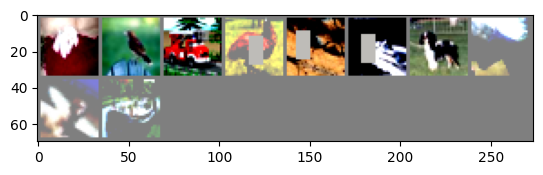

In [ ]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images[:10]))

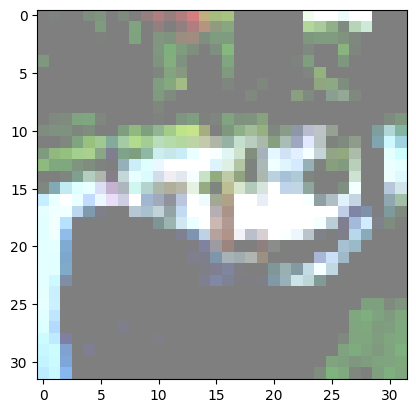

In [ ]:
image = images[9]
imshow(image)

In [ ]:
image = image.unsqueeze(0)
image = image.to(device)

In [ ]:
outputs = []
names = []
for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))
#print feature_maps
for feature_map in outputs:
    print(feature_map.shape)

In [ ]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    # gray_scale = feature_map[0]
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

In [ ]:
fig = plt.figure(figsize=(6, 10))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=10)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

<Figure size 600x1000 with 0 Axes>

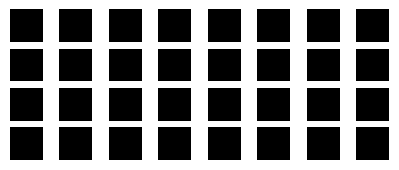

In [ ]:
# visualize the first conv layer filters
plt.figure(figsize=(5, 4))
first_layer_weights = model_weights[0].cpu()
for i, filter in enumerate(first_layer_weights):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')
plt.show()